Epoch: 0001 cost= 0.253437102
Epoch: 0006 cost= 0.125442729
Epoch: 0011 cost= 0.091587715
Epoch: 0016 cost= 0.078893715
Epoch: 0021 cost= 0.073983027
Epoch: 0026 cost= 0.071164837
Epoch: 0031 cost= 0.068112805
Epoch: 0036 cost= 0.065743477
Epoch: 0041 cost= 0.063543469
Epoch: 0046 cost= 0.059660450
Epoch: 0051 cost= 0.056229529
Epoch: 0056 cost= 0.051601711
Epoch: 0061 cost= 0.047798401
Epoch: 0066 cost= 0.043569364
Epoch: 0071 cost= 0.038903585
Epoch: 0076 cost= 0.036434158
Epoch: 0081 cost= 0.034417279
Epoch: 0086 cost= 0.032654840
Epoch: 0091 cost= 0.031149092
Epoch: 0096 cost= 0.029465447
Epoch: 0101 cost= 0.028302927
Epoch: 0106 cost= 0.026982048
Epoch: 0111 cost= 0.026038414
Epoch: 0116 cost= 0.025332600
Epoch: 0121 cost= 0.024873860
Epoch: 0126 cost= 0.024229553
Epoch: 0131 cost= 0.023829255
Epoch: 0136 cost= 0.023729050
Epoch: 0141 cost= 0.022701124
Epoch: 0146 cost= 0.022604803
Epoch: 0151 cost= 0.020945313
Epoch: 0156 cost= 0.020545272
Epoch: 0161 cost= 0.021038239
Epoch: 016

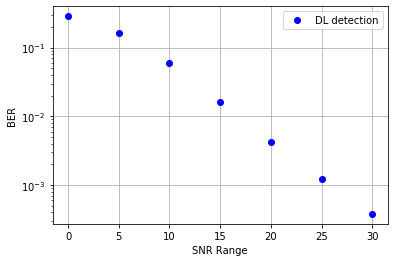

In [2]:
import numpy as np
import tensorflow as tf
from scipy.special import binom
#from keras import backend as K

N = 4 # number of sub-carriers
K = 3 # number of active sub-carriers
M = 4 # M-ary modulation order

SNRdb = 15 # Training SNR

traing_epochs = 1001
l_rate = 0.001 
total_batch = 20 # number of batches per epoch
batch_size = 1000

n_hidden_1 = 64 # smaller for Tanh, larger for ReLu
n_input = 3*N

m = int(np.log2(M))
c = int(np.log2(binom(N,K)))
q = K*m + c # number of bits per OFDM-IM symbol
Q = 2**q
n_output = q 

display_step = 5
SNR = 10**(SNRdb/10)
sigma = np.sqrt(1/SNR)
qam_factor = (2/3)*(M-1)

bits = np.random.binomial(n=1, p=0.5, size = (q,))
a = 1/np.sqrt(2)

# M-ary modulations
if M==4:
    QAM = np.array([1+1j, 1-1j, -1+1j, -1-1j], dtype=complex) # gray mapping
elif M==8:
    QAM = np.array([1, a+a*1j, -a+a*1j, 1j, a-a*1j, -1j, -1, -a-a*1j], dtype=complex) # 8PSK, not 8QAM indeed
    qam_factor = 1
elif M==16:
    QAM = np.array([-3+3j, -3+1j, -3-3j, -3-1j, 
                    -1+3j, -1+1j, -1-3j, -1-1j, 
                    3+3j, 3+1j, 3-3j, 3-1j, 
                    1+3j, 1+1j, 1-3j, 1-1j], dtype=complex)
else:
    QAM = np.array([1, -1], dtype=complex) #BPSK
    qam_factor = 1

power = np.sqrt(N/K/qam_factor) # power allocation factor

# index patterns for N=4 and K=1,2,3 only
if K==1:
    idx = np.array([[0],[1],[2],[3]])
elif K==2:
    idx = np.array([[0,1],[2,3],[0,2],[1,3]]) 
else:
    idx = np.array([[0,1,2],[1,2,3],[0,2,3],[0,1,3]]) 
    
def OFDM_IM_received(bits, SNRdb):   
    bit_id = bits[0:c:1]
    id_de = bit_id.dot(2**np.arange(bit_id.size)[::-1])
    
    bit_sy = bits[c:q:1]   
    bit_K = bit_sy.reshape(-1,m)
    sy_de = np.zeros((K,), dtype=int)
    sym = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i = bit_K[i,:]
        sy_de[i] = bit_sy_i.dot(2**np.arange(bit_sy_i.size)[::-1])
        sym[i] = QAM[sy_de[i]]

    tx_sym = np.zeros((N,), dtype=complex)
    tx_sym[idx[id_de,:]] = sym
    tx_sym = tx_sym*power
    
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    #eps = 1./(1 + SNR) # imperfect CSI
    eps = 0.0
    
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym.shape)+1j*np.random.randn(*tx_sym.shape))
    h = np.sqrt((1-eps)/2)*(np.random.randn(*tx_sym.shape)+1j*np.random.randn(*tx_sym.shape))
    e = np.sqrt(eps/2)*(np.random.randn(*tx_sym.shape)+1j*np.random.randn(*tx_sym.shape))
    h1 = h + e
    
    y = h1*tx_sym + noise
    y_bar = y/h
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y)
    Y = np.concatenate((y_con,y_m))

    return Y 

def OFDM_IM_received_test(bits, SNRdb):
    bit_id = bits[0:c:1]
    id_de = bit_id.dot(2 ** np.arange(bit_id.size)[::-1])

    bit_sy = bits[c:q:1]
    bit_K = bit_sy.reshape(-1, m)
    sy_de = np.zeros((K,), dtype=int)
    sym = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i = bit_K[i, :]
        sy_de[i] = bit_sy_i.dot(2 ** np.arange(bit_sy_i.size)[::-1])
        sym[i] = QAM[sy_de[i]]

    tx_sym = np.zeros((N,), dtype=complex)
    tx_sym[idx[id_de, :]] = sym
    tx_sym = tx_sym * power

    SNR = 10 ** (SNRdb / 10)
    sigma = np.sqrt(1 / SNR)
    #eps = 1./(1 + SNR) # imperfect CSI
    eps = 0.00

    noise = sigma * np.sqrt(1 / 2) * (np.random.randn(*tx_sym.shape) + 1j * np.random.randn(*tx_sym.shape))
    h = np.sqrt((1 - eps) / 2) * (np.random.randn(*tx_sym.shape) + 1j * np.random.randn(*tx_sym.shape))
    e = np.sqrt(eps / 2) * (np.random.randn(*tx_sym.shape) + 1j * np.random.randn(*tx_sym.shape))
    h1 = h + e

    y = h1 * tx_sym + noise
    y_bar = y / h
    y_con = np.concatenate((np.real(y_bar), np.imag(y_bar)))
    y_m = np.absolute(y)
    Y = np.concatenate((y_con, y_m))

    return Y  
   
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    weights = {                    
        'encoder_h1': tf.Variable(initializer([n_input, n_hidden_1])),
        'encoder_h2': tf.Variable(initializer([n_hidden_1, n_output])),            
    }
    biases = {            
        'encoder_b1': tf.Variable(initializer([n_hidden_1])),
        'encoder_b2': tf.Variable(initializer([n_output])),          
    
    }
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

y_pred = encoder(X)
y_true = Y

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

# Training and testing phases 
with tf.Session() as sess:
    # Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0.
        for index_m in range(total_batch):
            input_samples = []
            input_labels = []
            for index_k in range(0, batch_size):
                bits = np.random.binomial(n=1, p=0.5, size=(q,))
                signal_output = OFDM_IM_received(bits, SNRdb)  
                input_labels.append(bits)
                input_samples.append(signal_output)
 
            batch_x = np.asarray(input_samples)
            batch_y = np.asarray(input_labels)
            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_x,
                                                        Y:batch_y,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
 
    # Testing            
    EbNodB_range = list(frange(0,35,5))
    ber = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        input_samples_test = []
        input_labels_test = []
        test_number = 100000
        if n>10:
            test_number = 1000000
        for i in range(0, test_number):
            bits = np.random.binomial(n=1, p=0.5, size=(q, )) 
            signal_output = OFDM_IM_received_test(bits, EbNodB_range[n])
            input_labels_test.append(bits)
            input_samples_test.append(signal_output)
            
        batch_x = np.asarray(input_samples_test)
        batch_y = np.asarray(input_labels_test)
        
        #print('Predicted y is ', sess.run(tf.sign(y_pred-0.5), feed_dict = {X:batch_x}))
        #print('Batch_y is \n', sess.run(tf.cast(tf.sign(batch_y-0.5),tf.float32)))
        mean_error = tf.reduce_mean(abs(y_pred - batch_y)) # mean_error.eval({X:batch_x}),
        mean_error_rate = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_y-0.5),tf.float32))),1))
        ber[n]  = mean_error_rate.eval({X:batch_x}) # eval
        print("SNR=", EbNodB_range[n], "BER:", ber[n])
        
        
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, ber, 'bo',label='DL detection')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()